# The BB84 Protocol

## 1. Protocol Overview  

The protocol makes use of the fact that measuring a qubit can change its state. Thus, if Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it, this action can be detected.  

We import the needed packages first.

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from numpy.random import randint
import random
import numpy as np
%matplotlib inline

### 1.1 Simulation Technique 

If Alice prepares a qubit in the state $|+\rangle$ (i.e., `0` in the Horizontal basis), and Bob measures it in the same basis, Bob is sure to measure `0`. Since Qiskit's measurement device is fixed to use the Vertical basis (the Standard basis) as the reference, we need to introduce a technique to imitate the measurement referencing the Horizonal basis: 

**Measuring a qubit in the Horizontal basis is equivalent to applying Hadamard gate to it first and then measuring it in Vertical basis.**

The small circuit below verifies that this is true.

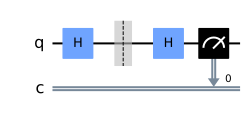

In [2]:
qc = QuantumCircuit(1,1)
# Applying Hadamard gate to convert qubit 0 to state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# We use a barrier to indicate this
qc.barrier()
# Measuring a qubit in the Horizontal basis is 
# equivalent to applying Hadamard gate and then measuring in Vertical basis
qc.h(0)
qc.measure(0,0)

# Draw the circuit
qc.draw()

Now let's run this circuit with `shots=1024` (the default) and plot the result.

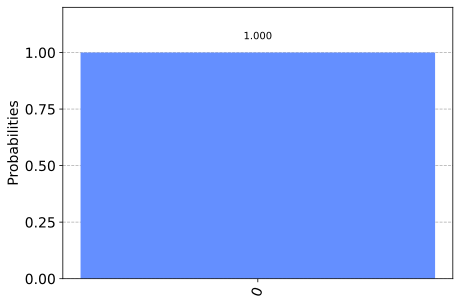

In [3]:
# Get the simulator
qsim = Aer.get_backend('qasm_simulator')
# Run the circuit
job = execute(qc, qsim)
# Plot the result
plot_histogram(job.result().get_counts())

We see the result is `0` with 100%, which verifies our technique. 

However, there is something missing in the above technique. In most cases, measurement is the last step in a quantum circuit, so the above technique is fine. But in some cases, we may need to continue to process that qubit after it is measured. In this case, we need to apply a H-gate after the measurement. This is because the measurement under the Horizontal basis collapses a qubit to either $|+\rangle$ or $|-\rangle$, but the measurement under the Vertical basis collapses a qubit to either $|0\rangle$ or $|1\rangle$. Thus, to restore the qubit to either $|+\rangle$ or $|-\rangle$, we need to apply a H-gate after the measurement. Therefore, if there is further processing after the measurement under the Horizontal basis, then

<b>Measuring a qubit in the Horizontal basis is equivalent to applying H-gate to it first, and then measuring it in Vertical basis, and finally applying H-gate to it again. </b>

That is, what we need to do is:

`
qc.h(0)
qc.measure(0,0)
qc.h(0)
`

This fact will be needed when we simulate the eavesdropper Eve, who may measure a qubit under the Horizontal basis and then pass the qubit to Bob for processing.

### 1.2 Basic Steps

The BB84 protocol basically has the following steps:

**- Step 1**

Alice chooses a string of random bits, e.g.:

`1000101011010100`

And a random choice of basis for each bit:

`VVHVHHHVHVHHHHHH`

Alice keeps these two pieces of information private to herself. 

**- Step 2**

Alice then encodes each bit onto a string of qubits using the basis she chose, this means each qubit is in one of the states $|0\rangle$, $|1\rangle$, $|+\rangle$ or $|-\rangle$, chosen at random. In this case, the string of qubits would look like this:

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

This is the message she sends to Bob.

**- Step 3**

Bob then measures each qubit at random, for example, he might use the bases:

`HVVVHVHVHVHVVVHV`

And Bob keeps the measurement results private.

**- Step 4**

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

**- Step 5**

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.


## 2. BB84 Demo: Without Eavesdropping

Let’s first see how the protocol works when no-one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. 

Let the length of Alice's initial message $n = 4 \times 25 = 100 $. That is, Alice will send a message of 100 qubits long:

In [4]:
n = 100

### 2.1 Step 1:

Alice generates her random set of bits:

In [5]:
## Step 1
# Alice generates random bits in [0, 1]
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1
 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0
 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1]


At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Quantum and Classical Channels in a table like this:

| Alice's Knowledge |Over Quantum and Classical Channels| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

### 2.2 Step 2:

Alice encodes each bit into qubit in the $H$ or $V$ basis at random, and stores the choices of bases in `alice_bases`. In this case, a `0` means "prepare in the $V$ basis", and a `1` means "prepare in the $H$ basis":

In [6]:
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0
 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0
 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1]


Alice also keeps this knowledge private:

| Alice's Knowledge |Over Quantum and Classical Channels| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

The function `encode_message` below creates a list of `QuantumCircuit`'s, with each containing a single qubit in Alice's message:

In [7]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Vertical Basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in Horizontal Basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [8]:
# Call the above function to create the list of quantum circuits
message = encode_message(alice_bits, alice_bases)

For example, let's print out the first bit in `alice_bits`, and the basis for this bit:

In [9]:
print('bit = ', alice_bits[0])
print('basis (0 means V, 1 means H) = ', alice_bases[0])

bit =  0
basis (0 means V, 1 means H) =  1


And if we view the first circuit in `message` (i.e., `message[0]`), we can verify that Alice has prepared a qubit based on the information above:

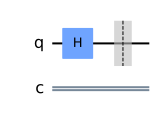

In [10]:
message[0].draw()

This message of qubits is then sent to Bob over the quantum channel:

| Alice's Knowledge |Over Quantum and Classical Channels| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

### 2.3 Step 3:

Bob then measures each qubit in the $H$ or $V$ basis at random and stores this information:

In [11]:
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1
 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0]


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Quantum and Classical Channels| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

Below, the function `measure_message` applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_bits`.

In [12]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: 
            # measuring in Vertical Basis
            message[q].measure(0,0)
        if bases[q] == 1: 
            # measuring in Horizontal Basis
            message[q].h(0)
            message[q].measure(0,0)
            message[q].h(0)  # restoring to |+> or |->
        
        message[q].barrier()
        
        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    
    return measurements

In [13]:
# Call the above function to conduct measurement
bob_bits = measure_message(message, bob_bases)

Let's again visualize the circuit `message[0]` after Bob's measurement:

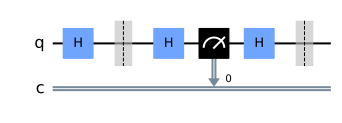

In [14]:
message[0].draw()

In [15]:
print(bob_bits)

[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]


Bob keeps his results private.

| Alice's Knowledge | Over Quantum and Classical Channels | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_bits   |

### 2.4 Step 4:

After this, Alice reveals which basis was used to encode each qubit through the Classical Channel, and Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Quantum and Classical Channels | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_bits   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_bits` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `get_identical` that does this for us:

In [16]:
def get_identical(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:

In [17]:
## Step 4
alice_same = get_identical(alice_bases, bob_bases, alice_bits)
bob_same = get_identical(alice_bases, bob_bases, bob_bits)
print(alice_same)
print(bob_same)

[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0]
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0]


| Alice's Knowledge | Over Quantum and Classical Channels | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_bits   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_same     |                    |     bob_same     |

### 2.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [18]:
def sample_bits(bits, selection):
    samples = []
    for i in selection:
        samples.append(bits[i])
        # label it as '-1' for later removal
        bits[i] = -1
     
    return samples

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [19]:
## Step 5
m = len(alice_same)
# Generate the indices for all bits in key
indices = list(range(0, m))
# Store the indices for half of the bits sampled randomly
selection = random.sample(indices, m//2)
alice_sample = sample_bits(alice_same, selection)
bob_sample = sample_bits(bob_same, selection)
print("alice_sample = ", str(alice_sample))
print("  bob_sample = ", str(bob_sample))

alice_sample =  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
  bob_sample =  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]


| Alice's Knowledge | Over Quantum and Classical Channels | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_bits   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_same     |                    |     bob_same     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

If the protocol has worked correctly without eavesdropping, their samples should match:

In [20]:
bob_sample == alice_sample

True

If their samples match, it means (with high probability) `alice_same == bob_same`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Quantum and Classical Channels | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_bits      |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_same    |                    |     bob_same    |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|    alice_remains  |                    |    bob_remains  |

In [21]:
# The final key agreed by alice and bob
alice_remains = []
for i in range(0, m):
        if alice_same[i] != -1:
            alice_remains.append(alice_same[i])
bob_remains = []
for i in range(0, m):
        if bob_same[i] != -1:
            bob_remains.append(bob_same[i])
print("alice_remains = ", str(alice_remains))
print("  bob_remains = ", str(bob_remains))
print("  key length  = ", len(alice_remains))

alice_remains =  [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
  bob_remains =  [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
  key length  =  26


## 3. BB84 Demo: With Eavesdropping

Let’s now see how Alice and Bob can tell if Eve has snooped into their quantum message. We repeat the same steps except that, before Bob receives his qubits, Eve measures them. 

### 3.1 Step 1:

Alice generates her set of random bits:

In [22]:
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0
 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1]


### 3.2 Step 2:

Alice encodes these in the $V$ and $H$-bases at random, and sends these to Bob through Eve's quantum channel:

In [23]:
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0
 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1]


### Interception!

Oh no! Eve intercepts the message as it passes through the quantum channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.

In [24]:
## Interception!!
eve_bases = randint(2, size=n)
eve_bits = measure_message(message, eve_bases)
print(eve_bits)

[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]


### 3.3 Step 3:

Eve then passes on the qubits to Bob, who measures them at random. In this case, Bob chose (by chance) to measure in the same basis Alice prepared the qubit in. Without interception, Bob would be guaranteed to measure `0`, but because Eve tried to read the message he now has a 50% chance of measuring `1` instead.

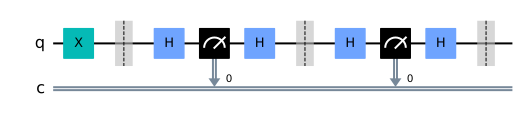

In [25]:
## Step 3
bob_bases = randint(2, size=n)
bob_bits = measure_message(message, bob_bases)
message[0].draw()

### 3.4 Step 4:

Bob and Alice reveal their basis choices, and discard the useless bits:

In [26]:
## Step 4
bob_same = get_identical(alice_bases, bob_bases, bob_bits)
alice_same = get_identical(alice_bases, bob_bases, alice_bits)

### 3.5 Step 5:

Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:

In [27]:
## Step 5
m = len(alice_same)
# Generate the indices for all bits in key
indices = list(range(0, m))
# Store the indices for half of the bits sampled randomly
selection = random.sample(indices, m//2)
alice_sample = sample_bits(alice_same, selection)
print("alice_sample = ", str(alice_sample))
bob_sample = sample_bits(bob_same, selection)
print("  bob_sample = ", str(bob_sample))

alice_sample =  [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]
  bob_sample =  [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]


In [28]:
bob_sample == alice_sample

False

Oh no! Bob's key and Alice's key do not match. We know this is because Eve tried to read the message between steps 2 and 3, and changed the qubits' states. For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve's interception attempt has failed.

## 5. Risk Analysis

For this type of interception, in which Eve measures all the qubits, there is a negligible tiny chance that Bob and Alice's samples could match. For how to calculate this chance, please refer to our lecture slides.

You can retry the protocol again by running the cell below. Try changing `sample_size` to something large and see how unlikely it is for Eve to intercept Alice and Bob's keys without being detected.

In [29]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
eve_bits = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_bits = measure_message(message, bob_bases)
# Step 4
bob_same = get_identical(alice_bases, bob_bases, bob_bits)
alice_same = get_identical(alice_bases, bob_bases, alice_bits)
# Step 5
sample_ratio = 0.5 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
m = len(alice_same)
# Generate the indices for all bits in key
indices = list(range(0, m))
# Store the indices for half of the bits sampled randomly
selection = random.sample(indices, int(m*sample_ratio))
alice_sample = sample_bits(alice_same, selection)
print("alice_sample = ", str(alice_sample))
bob_sample = sample_bits(bob_same, selection)
print("  bob_sample = ", str(bob_sample))
print("")
if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

alice_sample =  [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
  bob_sample =  [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]

Eve's interference was detected.
